In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import os
import sys
import argparse
import matplotlib.pyplot as plt
from torch_geometric.data import Data


KeyboardInterrupt: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:


from dotenv import dotenv_values

SECRETS = dotenv_values("../envs/graphs.env")

TRAIN_DATA_PATH = SECRETS['TRAIN_DATA_PATH']
TEST_DATA_PATH = SECRETS['TEST_DATA_PATH']
PULL_UP_STRENGTH, PULL_DOWN_STRENGTH = list(map(int, SECRETS['BETA'].split(':')))
NUM_SAMPLES = int(SECRETS['NUM_SAMPLES'])
MAX_LENGTH = int(SECRETS['MAX_LENGTH'])

In [260]:
1.05**12-1 - (1.03**12-1)

0.3700954391759508

In [15]:
def SIP_Amount(N:int, r:float, a:float, k:int, start:int=0):
    start_compounded = start*(1+r/12)**(N*12)
    val = np.sum([( min(k*(1+a*(i//12)), 2_500_000) ) *((1+r/12)**(N*12-i)) for i in range (N*12)])  + start_compounded

    invested = np.sum([min(k*(1+a*(i//12)), 2_500_000) for i in range (N*12)]) + start
    # val = np.sum([(k*(1+a*(i//12)) ) *((1+r/12)**(N*12-i)) for i in range (N*12+1)])
    # invested = np.sum([k*(1+a*(i//12)) for i in range (N*12+1)])
    return f"amount = {val:,}", f"invested = {invested:,}, returns = {val/invested:,}"

SIP_Amount(N=10, r=0.247, a=0.0, k=25_000, start = 0)

('amount = 13,052,306.010136552',
 'invested = 3,000,000.0, returns = 4.350768670045517')

In [4]:
data = np.load(TRAIN_DATA_PATH+f"/train_data/circuit{1}.npz")

In [5]:
train_data = [ (np.load(TRAIN_DATA_PATH + f"/train_data/circuit{i}.npz")['adj_list'],  np.load(TRAIN_DATA_PATH + f"/train_data/circuit{i}.npz")['feature_matrix']) for i in range(1, 1000+1) ]

In [12]:
def calculate_tax(income):
    slabs = [0, 300_000, 700_000, 1_000_000, 1_200_000, 1_500_000]
    rates = [0, 0.05, 0.1, 0.15, 0.2, 0.3]
    tax = 0
    for i in range(1, len(slabs)):
        if income >= slabs[i]:
            tax += rates[i-1] * (slabs[i] - slabs[i-1])
        else:
            tax += rates[i-1] * (income - slabs[i-1])
            return tax
    tax += rates[-1]*(income - slabs[-1])
    return tax


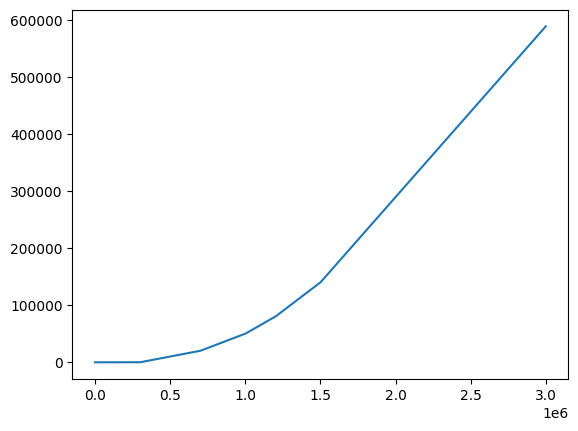

: 

In [20]:
incomes = np.arange(1_000, 3_000_000, 1_000)
taxes = [calculate_tax(income) for income in incomes]
plt.plot(incomes, taxes)

In [19]:
f"{calculate_tax(8_400_000):,}"

'2,210,000.0'

In [238]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Fetch historical data for NIFTY50
nifty50 = yf.Ticker("^NSEI")
# nifty50 = yf.Ticker("^GSPC")
history = nifty50.history(period="max")

# Display the first few rows
print(history.head())

# Save to CSV
# history.to_csv("NIFTY50_historical_data.csv")


                                  Open         High          Low        Close  \
Date                                                                            
2007-09-17 00:00:00+05:30  4518.450195  4549.049805  4482.850098  4494.649902   
2007-09-18 00:00:00+05:30  4494.100098  4551.799805  4481.549805  4546.200195   
2007-09-19 00:00:00+05:30  4550.250000  4739.000000  4550.250000  4732.350098   
2007-09-20 00:00:00+05:30  4734.850098  4760.850098  4721.149902  4747.549805   
2007-09-21 00:00:00+05:30  4752.950195  4855.700195  4733.700195  4837.549805   

                           Volume  Dividends  Stock Splits  
Date                                                        
2007-09-17 00:00:00+05:30       0        0.0           0.0  
2007-09-18 00:00:00+05:30       0        0.0           0.0  
2007-09-19 00:00:00+05:30       0        0.0           0.0  
2007-09-20 00:00:00+05:30       0        0.0           0.0  
2007-09-21 00:00:00+05:30       0        0.0           0.0  


In [239]:
def earliest_dates_per_month(date_list):
    # Convert the list of dates to a DatetimeIndex
    dates = pd.to_datetime(date_list)
    # Create a DataFrame to facilitate grouping
    df = pd.DataFrame({'date': dates})
    # Extract the year and month from the dates
    df['year_month'] = df['date'].dt.to_period('M')
    
    # Find the earliest date in each month
    earliest_dates = df.groupby('year_month')['date'].min().tolist()
    
    return earliest_dates


In [240]:
month_starts = history.loc[earliest_dates_per_month(history.index)]

C:\Users\adith\AppData\Local\Temp\ipykernel_17008\3926656570.py:7: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['date'].dt.to_period('M')


<Axes: xlabel='Date'>

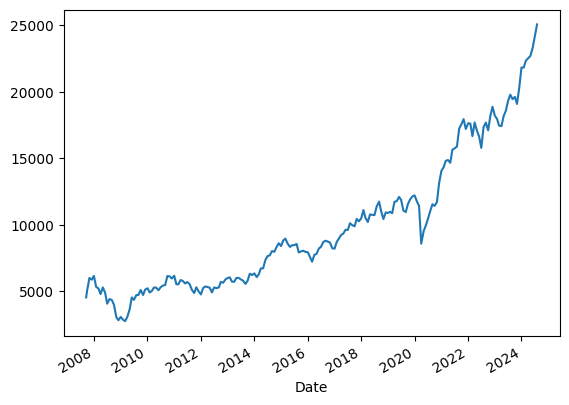

In [241]:
month_starts['High'].plot()

In [242]:
def CAGR(month_starts:pd.DataFrame, period:int):
    """
    Calculate the Compound Annual Growth Rate (CAGR) of a stock based on the monthly highs.
    month_starts: DataFrame with the monthly start dates and high prices
    period: number of months to consider for the return calculation
    """
    returns = []
    monthly_investment = 30000
    for i in range(len(month_starts) - period):
        num_units_bought = sum([monthly_investment/month_starts['High'].iloc[i+j] for j in range(period)])
        # num_units_bought = monthly_investment/month_starts['High'].iloc[i]
        total_value = month_starts['High'].iloc[i+period]*num_units_bought
        invested_value = monthly_investment*period
        # invested_value = monthly_investment
        returns.append((total_value - invested_value)/(invested_value))
        # returns.append((month_starts['High'].iloc[i+period] - month_starts['High'].iloc[i])/month_starts['High'].iloc[i])
    returns = [  100*((1+ret)**(12/period) - 1) for ret in returns]
    return returns

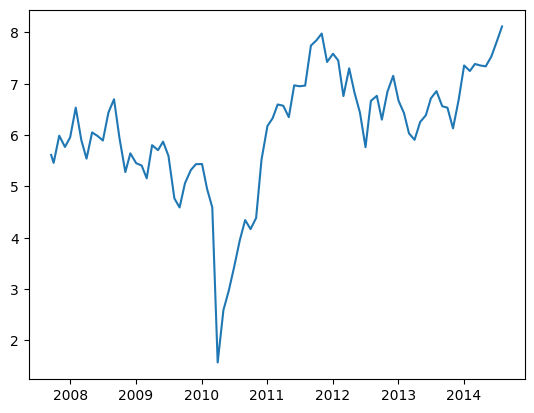

In [243]:
period_returns = CAGR(month_starts, 12*10)
plt.plot(month_starts.index[:len(period_returns)], period_returns)

In [244]:
np.mean(period_returns), np.std(period_returns), np.mean(period_returns)/np.std(period_returns)

(6.068685463674156, 1.2036090732678337, 5.042073542364963)

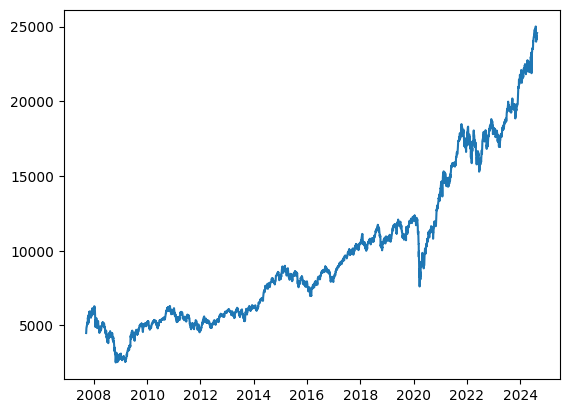

In [245]:

plt.plot(history.index, history['Close'])